In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('data/criterion_cleaned.csv')

in this notebook I'll be plotting a variety of initially very basic graphs. It will eventually become more sophisticated but for now I'm just aiming to get to know the data as fast as possible really.


**bar charts**

here, I just want the most basic shape info on some of these variables, starting with some count plots
hopefully this will start to form a picture of what the data actually is

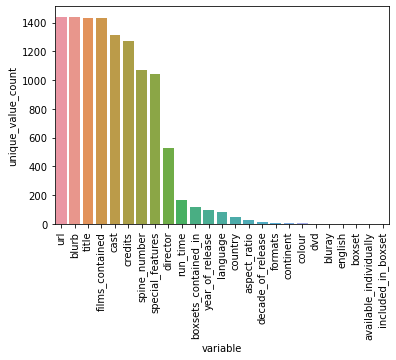

In [3]:
### unique value counts visualised ###

unique_vals = df.nunique().reset_index().sort_values(by=0, ascending=False)
unique_vals.columns = ['variable', 'unique_value_count']

sns.barplot(x='variable',
            y='unique_value_count',
            data=unique_vals)
plt.xticks(rotation=90)
plt.show()

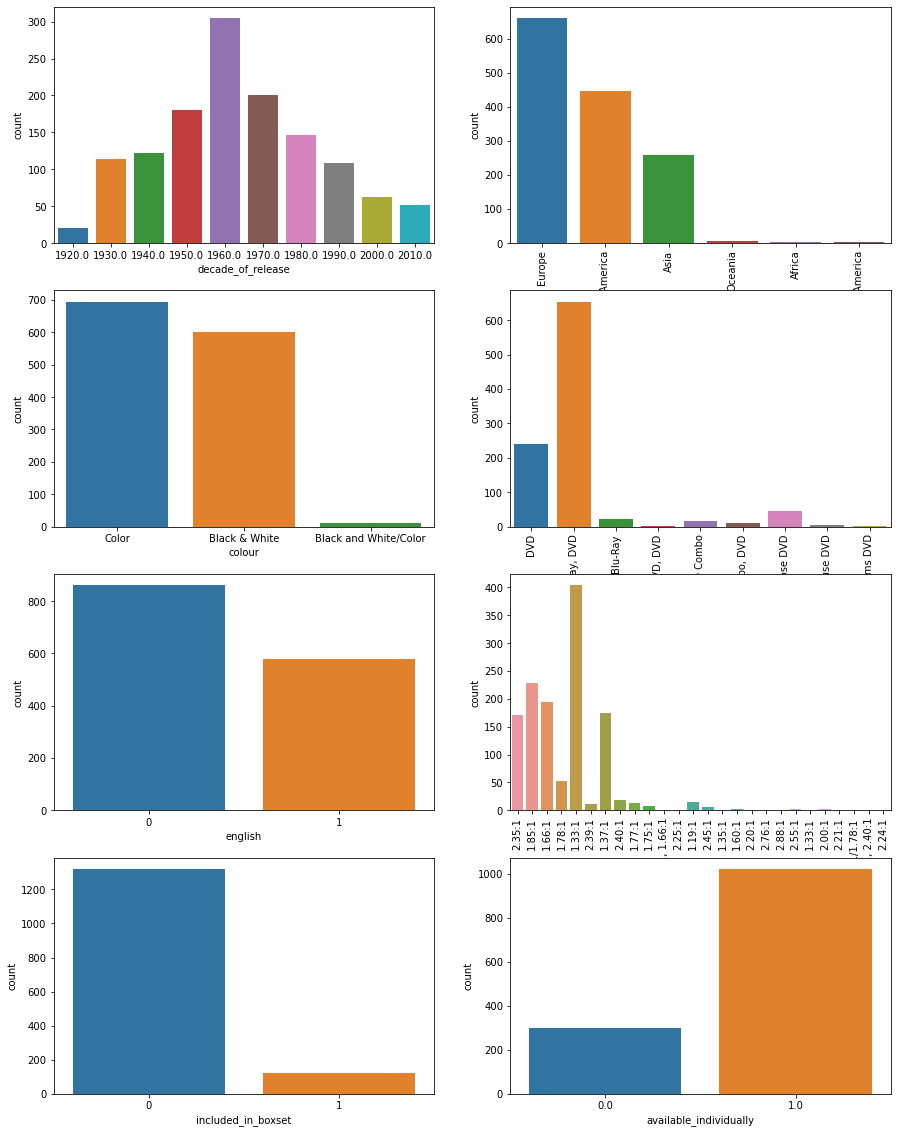

In [4]:
### value count plots for some arbitrary vars ###

count_plot_cols = [('decade_of_release', [0, 0]), 
                   ('continent', [0, 1]),
                   ('colour', [1, 0]),
                   ('formats', [1, 1]),
                   ('english', [2, 0]),
                   ('aspect_ratio', [2, 1]),
                   ('included_in_boxset', [3, 0]),
                   ('available_individually', [3, 1])]

fig, ax = plt.subplots(4, 2, figsize=(15, 20))

for col_tuple in count_plot_cols:
    sns.countplot(x=col_tuple[0], data=df,
                  ax=ax[col_tuple[1][0], col_tuple[1][1]])

for i in range(0, 3):
    plt.setp(ax[i, 1].xaxis.get_majorticklabels(), rotation=90)

plt.show()

a few initial insites:
- nice normal curve on decade of release
- wasnt expecting anything to be both black and white and colour really, wonder what films they are?
- interestingly very few films are solely on blu ray
- would be nice if I could read the axis hahaha
- there are a large number of aspect ratios that are basically unused
- 300 movies arent available individually. this is fewer than were included in boxsets...? something isnt adding up here there must be more movies with a null valued spine number who arent boxsets than i realised?
- of the movies with language data available, there are more without enlish than with

**Line Graphs**

this section will ocntain some basic line graph plots

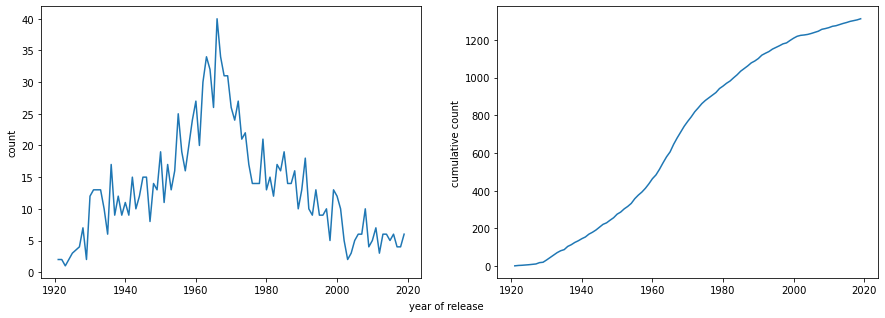

In [49]:
### basic line graphs for counts of releases per year ###

year_of_release_counts = pd.DataFrame(df.groupby('year_of_release').count()['country'])
year_of_release_counts.reset_index(inplace=True)
year_of_release_counts.columns = ['year_of_release', 'count']
year_of_release_counts['cumulative_count'] = year_of_release_counts['count'].cumsum()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot('year_of_release', 'count', data=year_of_release_counts)
ax[0].set_ylabel('count')

ax[1].plot('year_of_release', 'cumulative_count', data=year_of_release_counts)
ax[1].set_ylabel('cumulative count')

fig.text(0.5, 0.04, 'year of release', ha='center')

plt.show()

these are basic count plots for number of films released over time, again showing the general trend toward 1960's that we saw in the bar chat before. in all honesty not much has been gained from this but ack well guess its here now. wouldnt mind prehaps producing plot one again, but this time with separate lines for each value of certain variables (continent and colour jump out to me as semi interesting)